### Linear Shift-Invariant Image Filtering

Generally, filtering means neiborhood operation. And the term "linear shift-invariant image filtering" means to replace the pixels by a linear combination of their neighbors via a same rule. The rule is determined by the __kernal__ of the filtering. Note that the 

For example, $g[\cdot, \cdot] = \frac{1}{9}\, \begin{bmatrix}1& 1& 1\\ 1& 1& 1\\ 1& 1& 1\end{bmatrix}$ is called the __box filter__.
Then get the output $h[m,n]$ given kernal $g$ and signal $f[m, n]$ by 'convolution'
$$h[m, n] = \sum_{i, j} g[i, j]f[m + j, n + j]$$
It's not the convolution in _'Signals and Systems'_, and the idea is not similar.
Although $h(x) * g(x)$ is actually $g(x) * h(x)$, but here, in cv, we shift the image, not the _response_. It's more like a image to pass across a filter, not a filter processing a image

Another filter commonly used to blur an image is Gaussian Filter. Theoretically, it's 
$$g(\mathbf{x};\mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} e^{-\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu)}$$
In bivariate case, it could be simpler, as
$$ g(x, y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1 - \rho^2}} exp -\frac{1}{2(1 - \rho^2)} \Big(\frac{(x - \mu_x)^2}{\sigma_x^2} +\frac{(y - \mu_y)^2}{\sigma_y^2} - 2\rho\frac{(x - \mu_x)(y - \mu_y)}{\sigma_x\sigma_y} \Big)
$$
However, it need to be applied in a discrete environment. So firstly, we'd like to truncate the kernal, secondly, we need to determine the $\sigma$. A reasonable truncate is usually at 2-3$\sigma$. It's better to give kernal an odd length

---

When the rank of a filter is one, it could be constructed by a outer product of two vectors, which means that it could be splited into two steps and computed separately. This trick is useful for accelerating the process.
For a $M \times M$ image and a $N \times N$ kernal, before splitting, the cost is $N \times N \, \times \, M \times M$. After spliting, it will be $2 \times N \, \times \, M \times M$

In [1]:
import cv2

In [2]:
import numpy as np

In [5]:
from matplotlib import pyplot as plt

<img src="dataset/YoggSaron.jpg" alt="drawing" style="height:400px;"/>

In [128]:
img = cv2.imread('dataset/YoggSaron.jpg')

Let's start with a simple case $\to$ filtering a gray-scale image, which has only one channel

In [4]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Zero-padding:
`np.pad(imgGray, (#paddings at left-top,#paddings at right-bottom), 'constant', constant_values=(0, 0))`

In [127]:
def filtering_gray(kernel, f, ptype='constant'):
    h = np.empty_like(f)
    # we assume the kernal is squared and have an odd length
    lm = kernel.shape[0]
    ln = kernel.shape[1]

    padded = np.pad(f, [(lm // 2, lm // 2), (ln // 2, ln // 2)], ptype, constant_values=(0, 0))

    for m in range(h.shape[0]):
        for n in range(h.shape[1]):
            h[m][n] = np.sum(np.multiply(kernel, padded[m: m + lm, n: n + ln]))
    return h

In [99]:
z = lambda x, y, const, sigmaX, sigmaY, corr: const * np.exp(- 1 / (2 * np.sqrt(1 - corr ** 2)) * ( x ** 2 / sigmaX ** 2 + y ** 2 / sigmaY ** 2 - 2 * corr * x * y / sigmaX / sigmaY)     )
gauss = lambda x, sigmaX: 1 / (np.sqrt(2 * np.pi) * sigmaX) * np.exp(- 1 / 2 * x ** 2 / sigmaX ** 2)
def get_gaussian_kernel(k, sigmaX, sigmaY = 0, corr = 0):
    # k should be a tuple
    # it supports a covariance between x and y
    if not sigmaY:
        sigmaY = sigmaX
    m = k[0]
    n = k[1]
    y, x = np.ogrid[-m // 2 + 1: m // 2 + 1, - n // 2 + 1: n // 2 + 1]
    const = 1 / (2 * np.pi * sigmaX * sigmaY * np.sqrt(1 - corr ** 2)) 
    g = z(x, y, const, sigmaX, sigmaY, corr)
    #normalize
    return g / np.sum(g)

def get_separate_gaussian_kernel(k, sigmaX, sigmaY = 0):
    ## here x and y must be independent
    if not sigmaY:
        sigmaY = sigmaX
    m = k[0]
    n = k[1]
    y, x = np.ogrid[-m // 2 + 1: m // 2 + 1, - n // 2 + 1: n // 2 + 1]
    y = gauss(y, sigmaY)
    x = gauss(x, sigmaX)
    y /= np.sum(y)
    x /= np.sum(x)
    #normalize
    return y, x

In [103]:
box_filter = np.ones((3, 3)) / 9
gy, gx = get_separate_gaussian_kernel((3, 3), 1)
gm = get_gaussian_kernel((5, 3), 1)

In [122]:
blurred = filtering_gray(gm, imgGray)

In [ ]:
boxed 

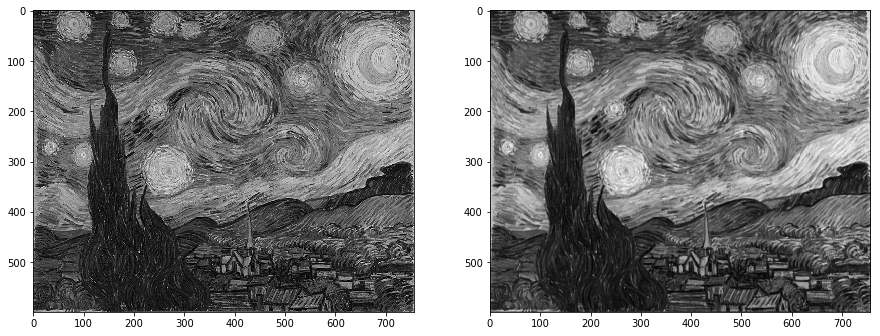

In [126]:
f, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(imgGray, cmap='gray')
axs[1].imshow(blurred, cmap='gray')